# Проект: Увеличение прибыльности магазина «В один клик»

Интернет-магазин «В один клик» продаёт различные товары, включая детские, домашние, бытовую технику, косметику и продукты. Недавний отчёт показал снижение активности покупателей. Привлечение новых клиентов стало менее эффективным, поэтому фокус сместился на удержание текущих клиентов через персонализированные предложения.

«В один клик» — современная компания, принимающая решения на основе данных и бизнес-моделирования. Ваша задача как стажёра в отделе цифровых технологий — разработать решение для персонализации предложений, чтобы повысить активность постоянных клиентов и поддержать их интерес к покупкам.

В ходе решения задачи необходимо будет выполнить следующие действия:

- Произвести обработку данных, проверка на пропуски, явные и неявные дубликаты;
- Описать данные с точки зрения их распределения - исследовательский анализ;
- Объединить всю необходимую информацию для обучения модели;
- Проанализировать корреляционную структуру данных;
- Построить пайплайн, который найдет лучшую модель для решения задачи;
- Определить важность каждого признака;
- Провести сегментацию покупателей и предложить идеи для улучшения работы с ними.

In [1]:
pip install missingno 

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install shap --upgrade

     |████████████████████████████████| 539 kB 1.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


### Загрузка данных

In [5]:
#Подключаем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
import missingno as msn
import seaborn as sns
import numpy as np
import warnings
import shap
import phik
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

In [6]:
#Убираем предупреждения
warnings.filterwarnings('ignore')

In [7]:
try:
    data_main = pd.read_csv('market_file.csv')
    data_money_duration = pd.read_csv('market_money.csv')
    data_time = pd.read_csv('market_time.csv')
    data_money_all = pd.read_csv('money.csv', sep=';', decimal=',')
except:
    data_main = pd.read_csv('/datasets/market_file.csv')
    data_money_duration = pd.read_csv('/datasets/market_money.csv')
    data_time = pd.read_csv('/datasets/market_time.csv')
    data_money_all = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

In [8]:
start_shape = data_main.shape[0]
print(data_main.info())
data_main.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [9]:
print(data_money_duration.info())
data_money_duration.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [10]:
print(data_time.info())
data_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [11]:
print(data_money_all.info())
data_money_all.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


**Вывод по первому шагу: На данном этапе проекта были подключены необходимые для работы библиотеки. Загружены 4 таблицы. Таблица data_money_all не корректно загружалась, поэтому при чтении файлов были использованы дополнительные параметры для корректного отображения вещественных чисел и столбцов. Также выведена общая информация по датасетам и первые 5 строк.**

### Предобработка данных

#### Проверка на пропуски

<AxesSubplot:>

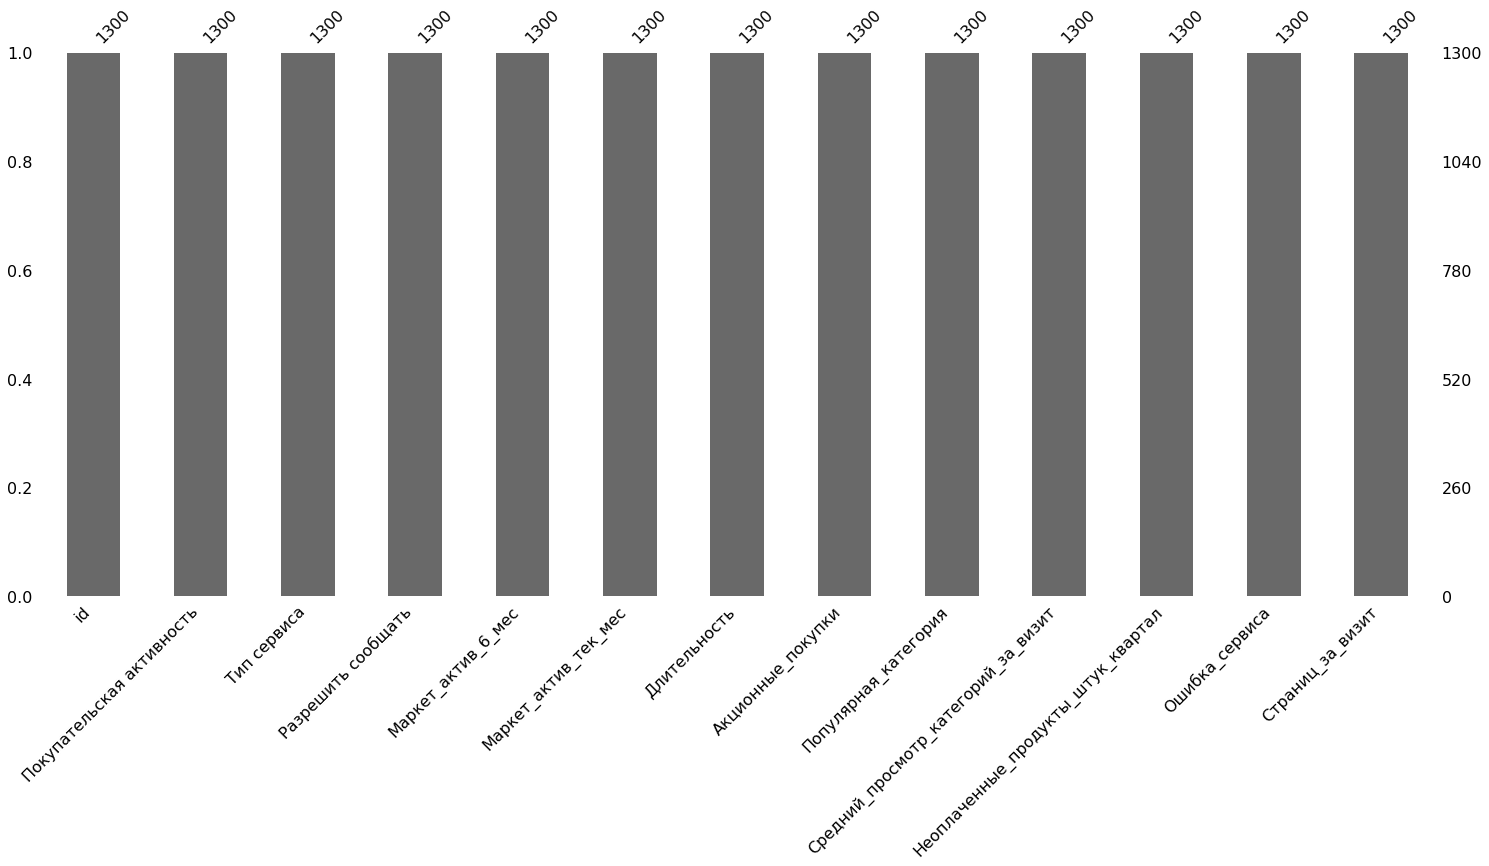

In [12]:
msn.bar(data_main)

<AxesSubplot:>

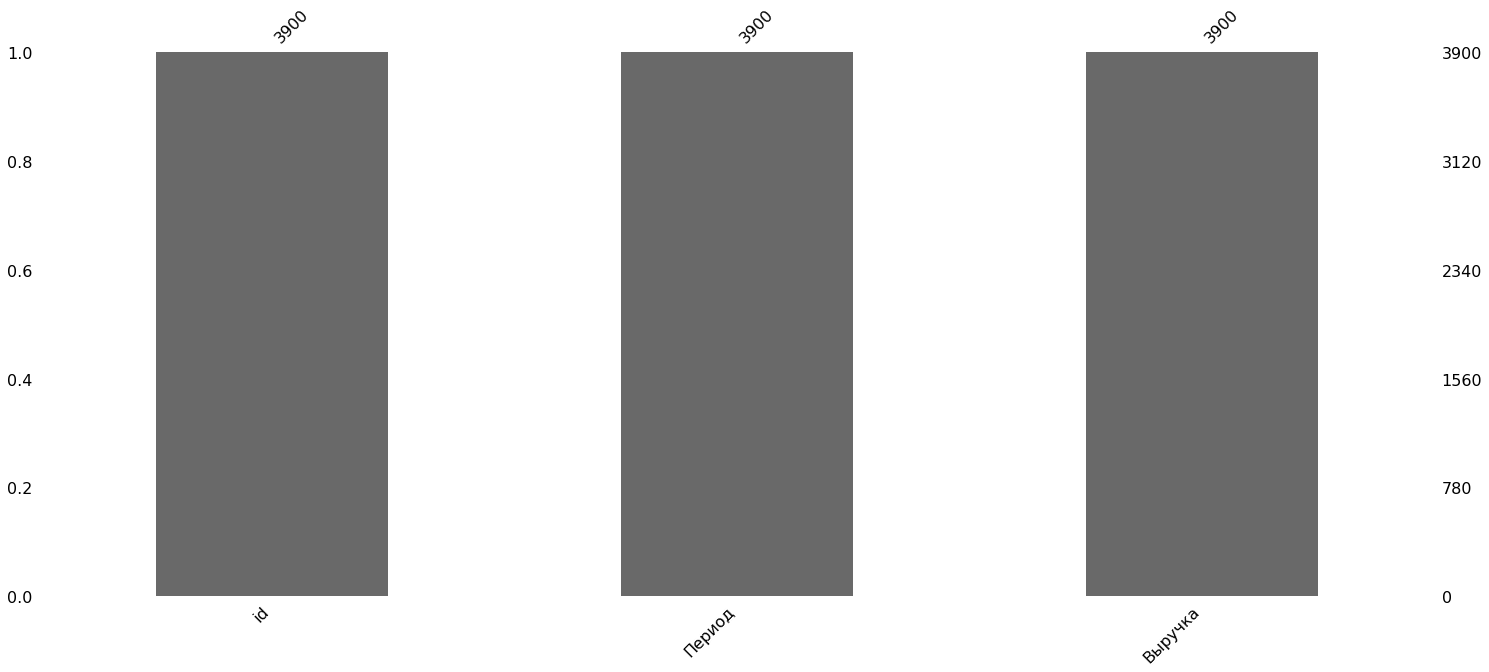

In [13]:
msn.bar(data_money_duration)

<AxesSubplot:>

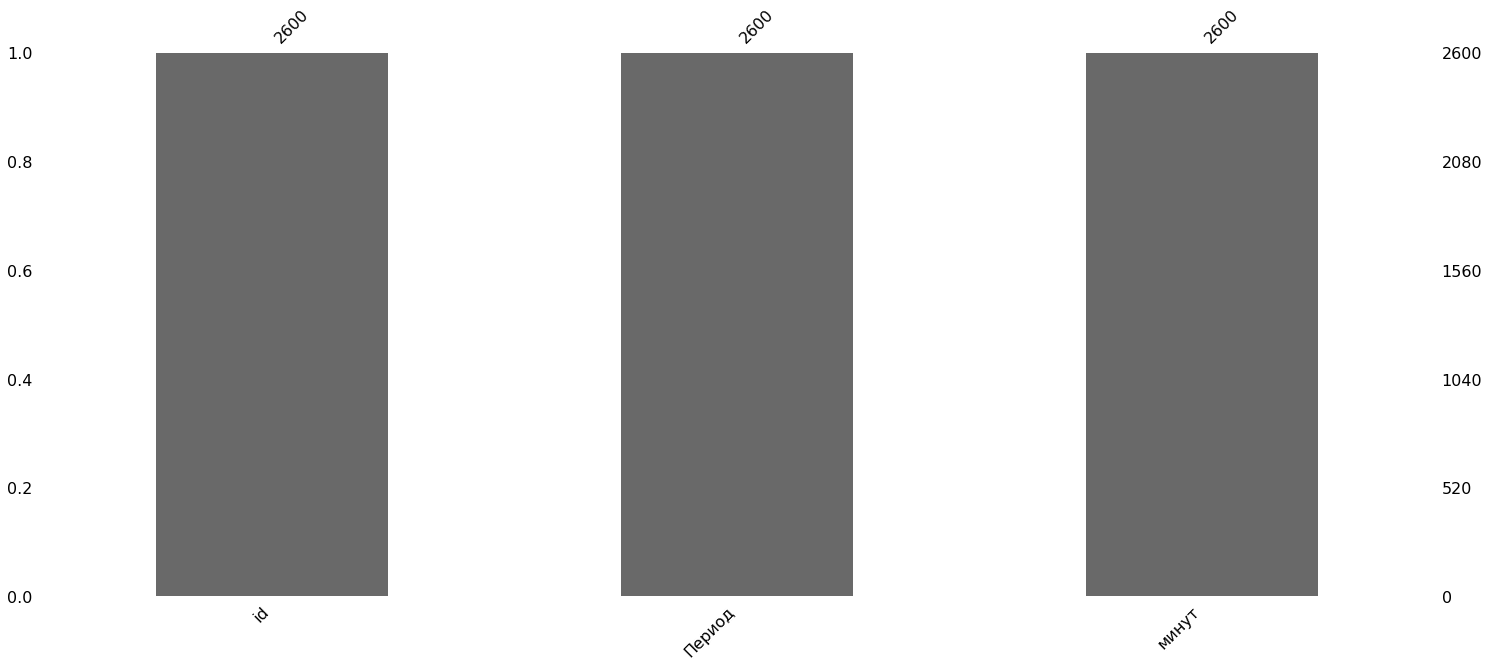

In [14]:
msn.bar(data_time)

<AxesSubplot:>

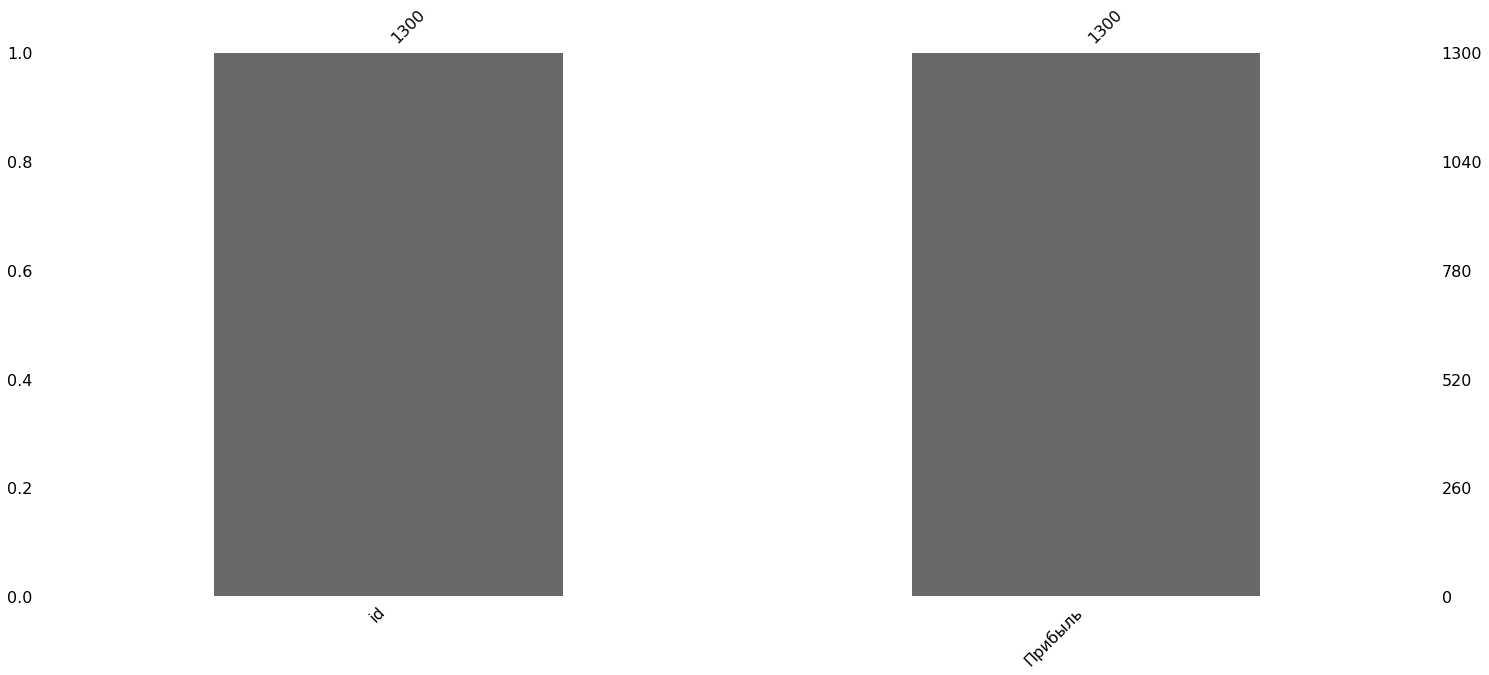

In [15]:
msn.bar(data_money_all)

**Вывод: Согласно полученным диаграммам пропусков в данных не обнаружено.**

#### Проверка на дубликаты

In [16]:
data_main.duplicated().sum()

0

In [17]:
data_money_duration.duplicated().sum()

0

In [18]:
data_time.duplicated().sum()

0

In [19]:
data_money_all.duplicated().sum()

0

**Вывод: Явных дубликатов в данных не обнаружено.**

#### Изменим названия столбцов

In [20]:
data_main.columns

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

In [21]:
data_money_duration.columns

Index(['id', 'Период', 'Выручка'], dtype='object')

In [22]:
data_time.columns

Index(['id', 'Период', 'минут'], dtype='object')

In [23]:
data_money_all.columns

Index(['id', 'Прибыль'], dtype='object')

**Для работы необходимо перевести все названия в нижний регистр и обратить названия столбцов в змеиный стиль.(в условии хоть и сказано, что оставить вроде как, но мне кажется как миниму эти действия надо сделать))))**

In [24]:
data_main.columns = data_main.columns.str.lower()
data_money_duration.columns = data_money_duration.columns.str.lower()
data_time.columns = data_time.columns.str.lower()
data_money_all.columns = data_money_all.columns.str.lower()

In [25]:
data_main = data_main.rename(columns={'покупательская активность':'покупательская_активность',
                                      'тип сервиса':'тип_сервиса',
                                      'разрешить сообщать':'разрешить_сообщать'})

In [26]:
#Проверка на корректность изменения названий столбцов
print('1 датасет ' + '-' * 10, '\n', data_main.columns)
print('2 датасет ' + '-' * 10, '\n', data_money_duration.columns)
print('3 датасет ' + '-' * 10, '\n', data_time.columns)
print('4 датасет ' + '-' * 10, '\n', data_money_all.columns)

1 датасет ---------- 
 Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')
2 датасет ---------- 
 Index(['id', 'период', 'выручка'], dtype='object')
3 датасет ---------- 
 Index(['id', 'период', 'минут'], dtype='object')
4 датасет ---------- 
 Index(['id', 'прибыль'], dtype='object')


#### Проверка на неявные дубликаты

In [27]:
print(data_main['покупательская_активность'].unique())
print(data_main['тип_сервиса'].unique())
print(data_main['популярная_категория'].unique())
print(data_time['период'].unique())
print(data_money_duration['период'].unique())

['Снизилась' 'Прежний уровень']
['премиум' 'стандартт' 'стандарт']
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
['текущий_месяц' 'предыдцщий_месяц']
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


**Видим, что в таблице data_main, есть не корретное название категории "стандарт" и "стандартт", также в data_time слово предыдущий содержит ошибку. Исправим недочеты.**

In [28]:
data_main['тип_сервиса'] = data_main['тип_сервиса'].replace('стандартт', 'стандарт')
data_time['период'] = data_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

**Вывод по второму шагу: По итогу предобработки пропусков и явных дубликатов в данных не было обнаружено. Немного изменены названия столбцов, приведено все к нижнему регистру. Проведена проверка на неявные дубликаты, они были обнаружены и корректно исправлены.**

### Исследовательский анализ данных

In [29]:
#Функция для построения круговой диаграммы
def pie_plot(data, column):
    plt.pie(data[column].value_counts(), labels=data[column].unique(), autopct='%1.2f%%',
    textprops={'fontsize':10})
    plt.title("Распределение значений столбца " + column)
    plt.show()

In [30]:
#Функция для построения гистограммы диаграммы (непрерывные данные)
def hist_plot_continuous(data, column, string_1):
    plt.hist(data[column])
    plt.xlabel(string_1)
    plt.ylabel('Частота')
    plt.title("Распределение значений столбца " + column)
    plt.show()

In [31]:
#Функция для построения гистограммы диаграммы (дискретные данные)
def hist_plot_discrete(data, column, string_1):
    sns.countplot(data[column])
    plt.xlabel(string_1)
    plt.ylabel('Частота')
    plt.title("Распределение значений столбца " + column)
    plt.show()

#### data_main

In [32]:
data_main.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

In [33]:
data_main.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


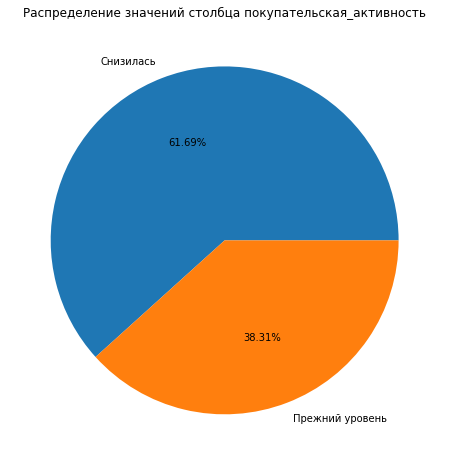

In [34]:
pie_plot(data_main, 'покупательская_активность')

**Покупатели, у которых активность снизилась, превосходят покупателей с прежним уровнем активности.**

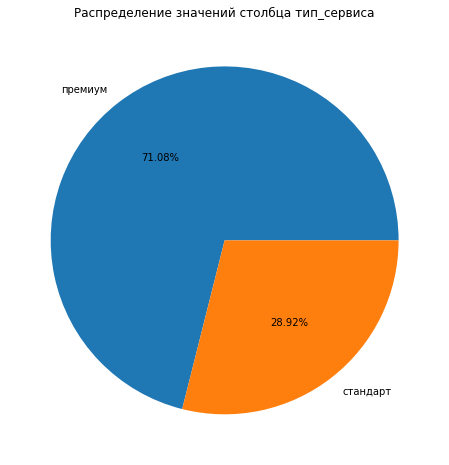

In [35]:
pie_plot(data_main, 'тип_сервиса')

**Покупателей с премиум аккаунтом почти в 2,5 раза больше, чем обычных, видимо действительно покупка премиум сервиса дает удовольствие покупателям и оправдывает свои деньги.**

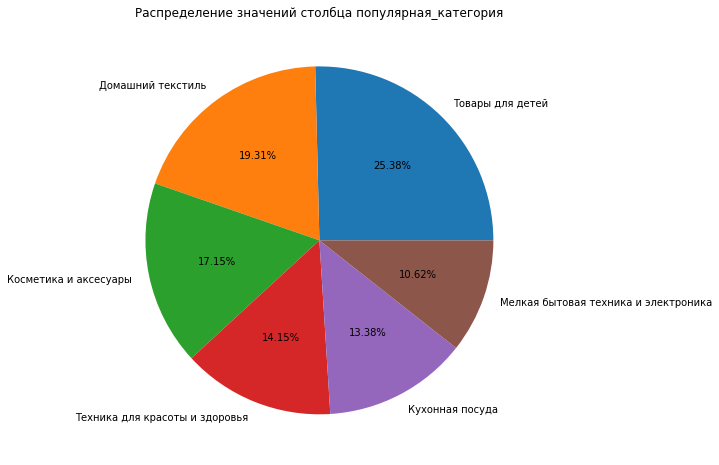

In [36]:
pie_plot(data_main, 'популярная_категория')

**Пользователей онлайн магазина больше интересуют товары для детей, а меньше всего мелкая бытовая техника и электроника.**

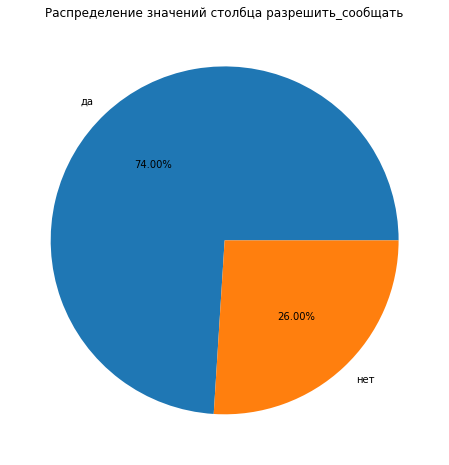

In [37]:
pie_plot(data_main, 'разрешить_сообщать')

**Согласно полученному распределению покупателей действительно интересуют дополнительная информация о товарах и спец-предложениях о них**

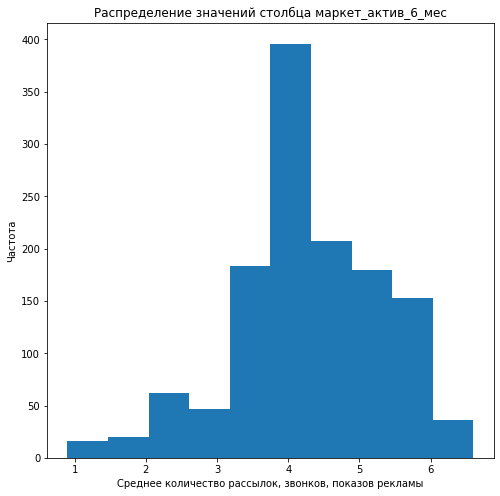

In [38]:
hist_plot_continuous(data_main, 'маркет_актив_6_мес', 'Среднее количество рассылок, звонков, показов рекламы')

**Среднемесячный показатель маркетинговых коммуникаций равен 4, столько раз в среднем компания производит связь с клиентом и продвигает себя.**

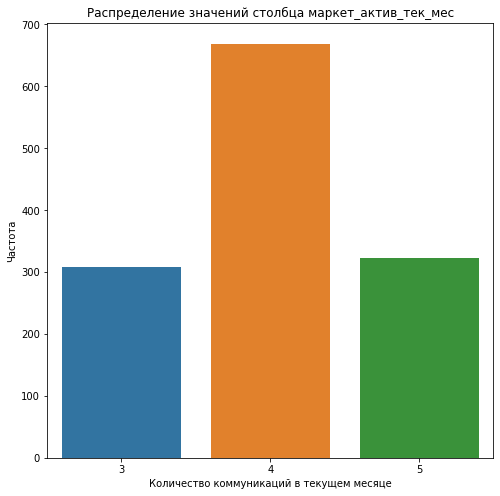

In [39]:
hist_plot_discrete(data_main,'маркет_актив_тек_мес', 'Количество коммуникаций в текущем месяце')

**Текущий месяц подтверждает общее распределения маркетинговых коммуникаций, чаще всего делалось по 4 действия.**

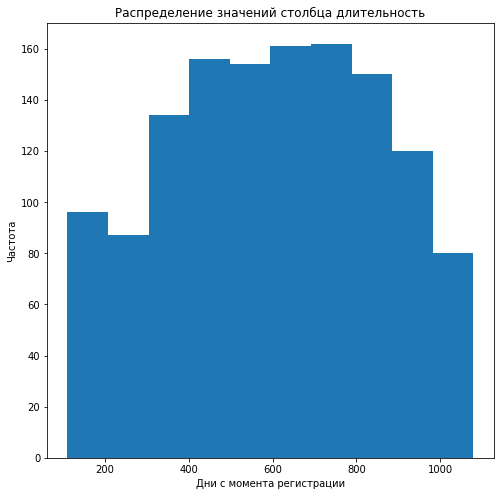

In [40]:
hist_plot_continuous(data_main, 'длительность', 'Дни с момента регистрации')

**Данные предоставлены с клиентами, которые пользуются сервисами как минимум около 3-х месяцев и до полугода.**

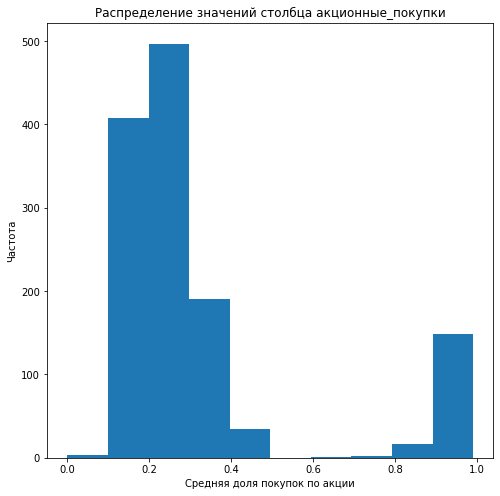

In [41]:
hist_plot_continuous(data_main, 'акционные_покупки', 'Средняя доля покупок по акции')

**Акционные товары редко интересуют клиентов, в основном за последние 6 месяцев показатель колеблется от 0.1 до 0.4 с пиком в 0.2 долей товаров.**

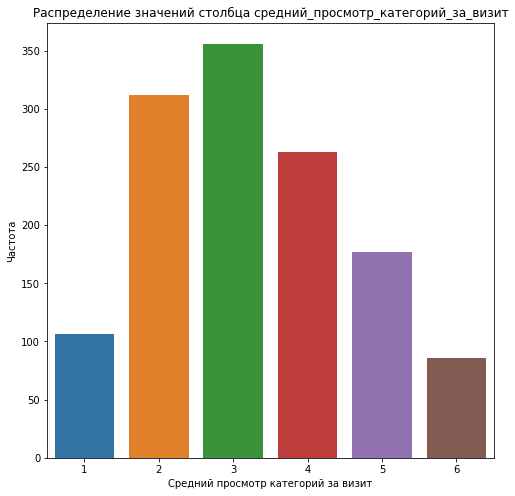

In [42]:
hist_plot_discrete(data_main, 'средний_просмотр_категорий_за_визит', 'Средний просмотр категорий за визит')

**Признак  дискретный, но все равно распределение похоже на нормальное. Чаще всего пользователи интересуются 3 категориями в процессе просмотра своих желаемых покупок.**

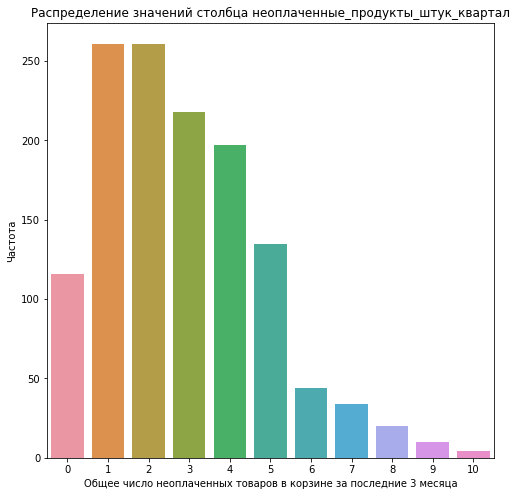

In [43]:
hist_plot_discrete(data_main, 'неоплаченные_продукты_штук_квартал', 
                   'Общее число неоплаченных товаров в корзине за последние 3 месяца')

**Больше всего неоплаченных товаров в корзине у клиентов это 2-3 товара, но есть и такие, которые откладывают и 10 вещей на будущие покупки, либо ожидание на них скидок.**

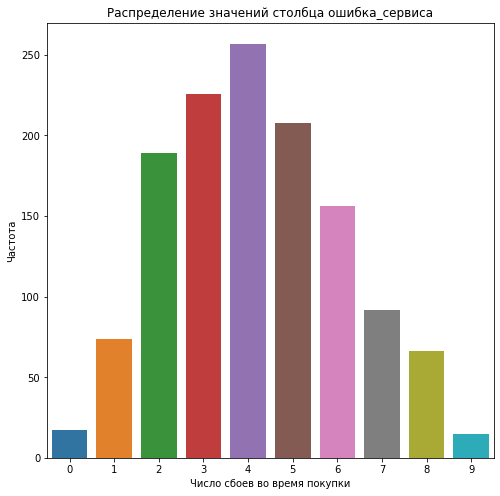

In [44]:
hist_plot_discrete(data_main, 'ошибка_сервиса', 'Число сбоев во время покупки')

**Второй признак распределение которого напоминает нормально. По нему можно сказать, что чаще всего случается 4 сбоя при попытки оплатить товар.**

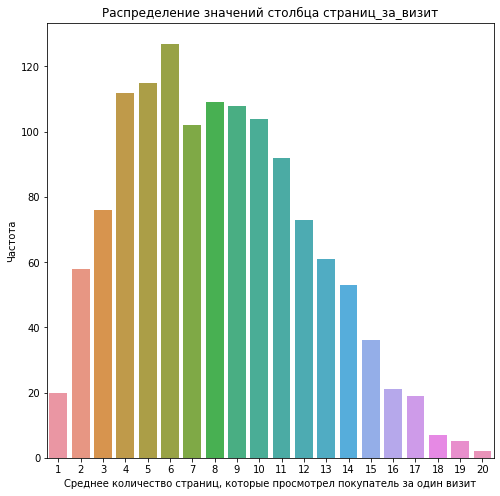

In [45]:
hist_plot_discrete(data_main, 'страниц_за_визит', 'Среднее количество страниц, которые просмотрел покупатель за один визит')

**Чаще всего покупатели просматривают от 5 до 10 страниц за посещение интернет-магазина.**

#### data_money_duration

In [46]:
data_money_duration.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


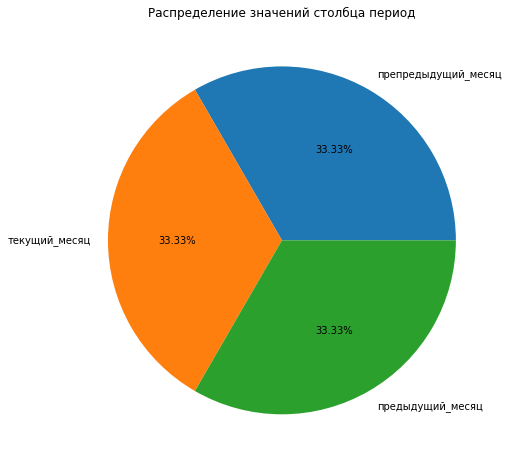

In [47]:
pie_plot(data_money_duration, 'период')

**Данные предоставлены за 3 последний месяца, количество информации о каждом месяце одинаково.**

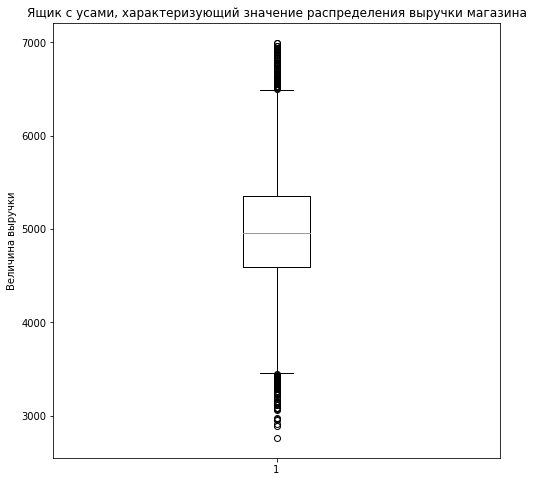

In [48]:
plt.boxplot(data_money_duration.query('0 < выручка < 7000')['выручка'])
plt.ylabel('Величина выручки')
plt.title('Ящик с усами, характеризующий значение распределения выручки магазина')
plt.show()

**В data_money_duration был обнаружен выброс, который показывать выручку больше чем в 100_000, возможно такая покупка и была произведена, но она не согласуется с остальными данными. Также есть клиент, которые ничего не купил за предоставленный период, он тоже не подходит под общую массу.**

#### data_time

In [49]:
data_time.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


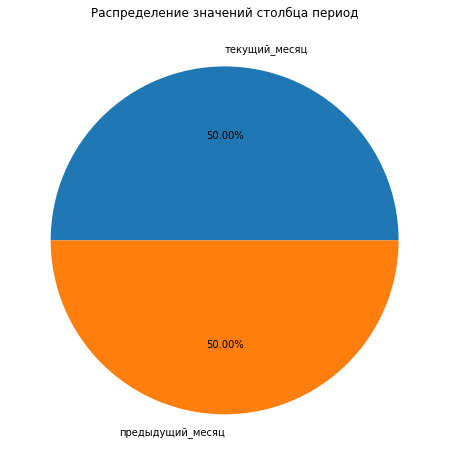

In [50]:
pie_plot(data_time, 'период')

**Данные о времени нахождения на сайте предоставлены в равном количестве за 2 месяца.**

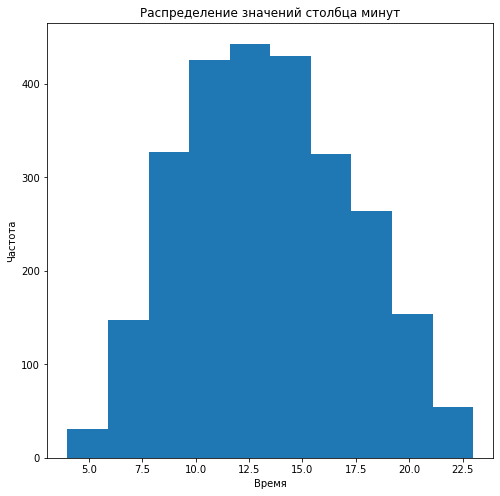

In [51]:
hist_plot_continuous(data_time, 'минут', 'Время')

**Снова можно заметить нормальное распределения из которого следует, что чаще всего пользователи находятся в поиске покупок от 10 до 15 минут.**

#### data_money_all

In [52]:
data_money_all.head()

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


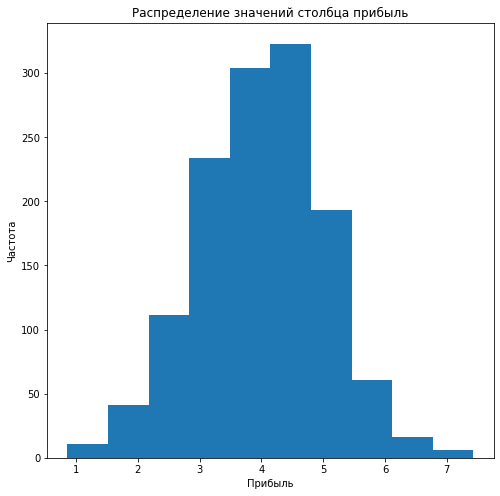

In [53]:
hist_plot_continuous(data_money_all, 'прибыль', 'Прибыль')

**В среднем магазин получает прибыль от 4 до 5 тысяч рублей от покупателя.**

In [54]:
#Фильтрация таблицы, исключение клиентов, у которых не было активности хотя бы в 1 из 3 месяцев
id_null_money = data_money_duration.query('выручка == 0')['id'].unique()

In [55]:
id_much_money = data_money_duration.query('выручка > 8000')['id'].unique()

In [56]:
print(id_null_money)
print(id_much_money)
data_main_active = data_main[~data_main['id'].isin(id_null_money)]
data_main_active = data_main_active[~data_main_active['id'].isin(id_much_money)]
data_main_active.shape

[215348 215357 215359]
[215380]


(1296, 13)

**Вывод по итогу 3 шага: В ходе данной части проекта были построены множественные диаграммы с помощью которых можно улучшить датасет, а именно: отобрать основную массу покупателей, исключить тех, у которых прибыль 0 и у которых она слишком большая.**

### Объединение таблиц

In [57]:
#Сводная таблица по месяцам
revenue_pivot = data_money_duration.pivot(index='id', columns='период', values='выручка').reset_index()
revenue_pivot.head()

период,id,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
0,215348,0.0,0.0,3293.1
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4
3,215351,6158.0,4793.0,6610.4
4,215352,5807.5,4594.0,5872.5


In [58]:
#Сводная таблица по месяцам
time_spent_pivot = data_time.pivot(index='id', columns='период', values='минут').reset_index()
time_spent_pivot.head()

период,id,предыдущий_месяц,текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


In [59]:
data_big = data_main_active.merge(revenue_pivot, on='id', how='left').merge(time_spent_pivot, on='id', how='left')
data_big.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_x,препредыдущий_месяц,текущий_месяц_x,предыдущий_месяц_y,текущий_месяц_y
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [60]:
data_big = data_big.rename(columns = {'предыдущий_месяц_x':'предыдущий_месяц_выручка',
                                      'препредыдущий_месяц':'препредыдущий_месяц_выручка',
                                      'текущий_месяц_x':'текущий_месяц_выручка',
                                      'предыдущий_месяц_y':'предыдущий_месяц_время',
                                      'текущий_месяц_y':'текущий_месяц_время'})
data_big.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_время,текущий_месяц_время
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


**Вывод по итогу 4 шага: Обработаны таблицы data_money_duration, data_time и было произвдено объединение с data_main_active. Изменены названия столбцов.**

### Корреляционный анализ

In [61]:
phik_matrix = data_big.drop(columns='id').phik_matrix(interval_cols=['маркет_актив_6_мес', 
                                                       'длительность', 
                                                       'акционные_покупки', 
                                                       'препредыдущий_месяц_выручка', 
                                                       'предыдущий_месяц_выручка', 
                                                       'текущий_месяц_выручка'])

phik_matrix

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_время,текущий_месяц_время
покупательская_активность,1.000000,0.129940,0.000000,0.544831,0.000000,0.099901,0.506276,0.299717,0.539607,0.405041,0.224154,0.747331,0.224638,0.497393,0.197213,0.604355,0.569983
тип_сервиса,0.129940,1.000000,0.289965,0.089911,0.045258,0.401411,0.030010,0.070809,0.185391,0.113015,0.079515,0.087776,0.000000,0.069704,0.124216,0.121210,0.061764
разрешить_сообщать,0.000000,0.289965,1.000000,0.000000,0.052618,0.253831,0.012198,0.073684,0.070359,0.162524,0.021839,0.097094,0.080842,0.000000,0.060907,0.063528,0.000000
маркет_актив_6_мес,0.544831,0.089911,0.000000,1.000000,0.079854,0.000000,0.279553,0.150386,0.206788,0.217731,0.142401,0.376035,0.155476,0.315331,0.039795,0.322830,0.331480
маркет_актив_тек_мес,0.000000,0.045258,0.052618,0.079854,1.000000,0.174233,0.000000,0.136243,0.246633,0.142887,0.116946,0.000000,0.051824,0.000000,0.000000,0.166871,0.079883
длительность,0.099901,0.401411,0.253831,0.000000,0.174233,1.000000,0.000000,0.000000,0.186795,0.128222,0.175608,0.128089,0.125572,0.113200,0.147048,0.046299,0.021117
акционные_покупки,0.506276,0.030010,0.012198,0.279553,0.000000,0.000000,1.000000,0.122385,0.199180,0.246665,0.000000,0.350714,0.060733,0.226381,0.071094,0.314140,0.287292
популярная_категория,0.299717,0.070809,0.073684,0.150386,0.136243,0.000000,0.122385,1.000000,0.226116,0.254746,0.000000,0.177637,0.252097,0.043528,0.237240,0.218727,0.113774
средний_просмотр_категорий_за_визит,0.539607,0.185391,0.070359,0.206788,0.246633,0.186795,0.199180,0.226116,1.000000,0.334927,0.070315,0.293781,0.098440,0.176828,0.092597,0.219174,0.236298
неоплаченные_продукты_штук_квартал,0.405041,0.113015,0.162524,0.217731,0.142887,0.128222,0.246665,0.254746,0.334927,1.000000,0.000000,0.310843,0.193536,0.189320,0.166017,0.194298,0.158243


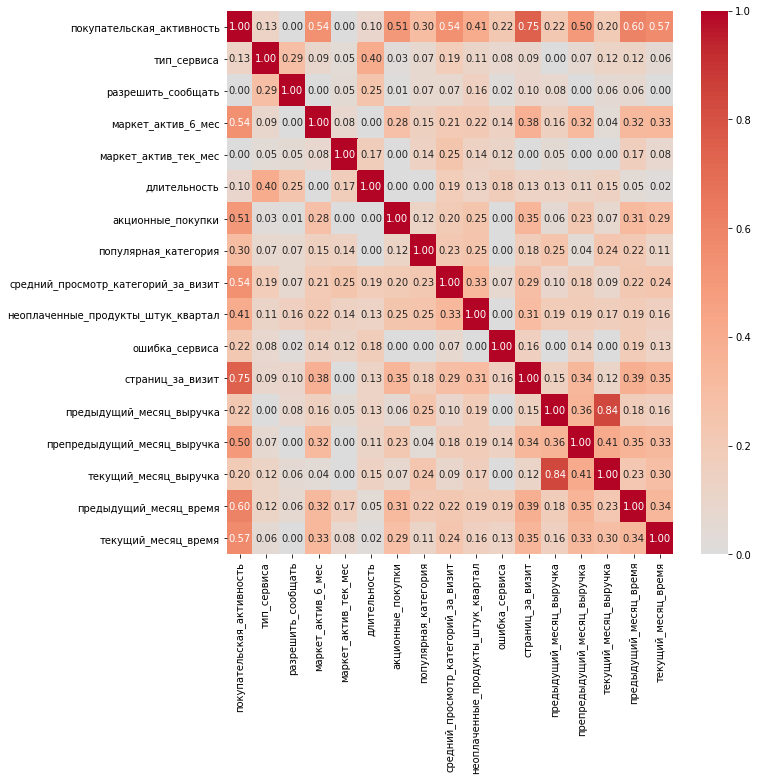

In [62]:
plt.figure(figsize=(10, 10))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.show()

In [63]:
data_big_new = data_big.drop(['препредыдущий_месяц_выручка','текущий_месяц_время', 'предыдущий_месяц_выручка'], axis=1)

**Вывод по пятому шагу:  Было обнаружено, что признаки препредыдущий_месяц_выручка, текущий_месяц_время и предыдущий_месяц_время имеют практически одинаковую корреляционную структуру, поэтому 3 признака можно описать одним. Было решено оставить предыдущий_месяц_время. Также по структуре схожи текущий_месяц_выручка и предыдущий_месяц_выручка, их тоже можно описать одним признаком, был убран предыдущий месяц выручка.**

### Построение модели с использованием пайплайнов

In [64]:
# Просмотр датасета на котором будет строиться модель
data_big_new.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,текущий_месяц_выручка,предыдущий_месяц_время
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,12
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,8
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,11
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,8
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,10


In [65]:
#Формирование групп признаков
RANDOM_STATE = 42
num_columns = ['маркет_актив_6_мес',
               'маркет_актив_тек_мес',
               'длительность',
               'акционные_покупки',
               'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал',
               'ошибка_сервиса',
               'текущий_месяц_выручка',
               'страниц_за_визит',
               'предыдущий_месяц_время']
ohe_columns = ['разрешить_сообщать']
ord_columns = ['тип_сервиса', 'популярная_категория']

In [66]:
# Пайплайн с OneHotEncoder кодированием
ohe_pipe = Pipeline([
                    ('simple_Imputer_ohe',
                      SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                    ('ohe',
                     OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
                   ])

In [67]:
data_big_new['популярная_категория'].value_counts()

Товары для детей                        329
Домашний текстиль                       250
Косметика и аксесуары                   223
Техника для красоты и здоровья          182
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64

In [68]:
# Пайплайн с OrdinalEncoder кодированием
ord_pipe = Pipeline(
                [('simple_Imputer_before_ord',
                   SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                 ('ord',
                  OrdinalEncoder(categories=[['стандарт', 'премиум'],
                                             ['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары', 
                                              'Техника для красоты и здоровья', 'Мелкая бытовая техника и электроника', 
                                              'Кухонная посуда']
                                            ], 
                                            handle_unknown='use_encoded_value', 
                                            unknown_value=np.nan)),
                 ('simple_Imputer_after_ord',
                   SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
                ])

In [69]:
# Общий пайплайн со всеми преобразованиями
data_preprocessor = ColumnTransformer([
                                      ('ohe', ohe_pipe, ohe_columns),
                                      ('ord', ord_pipe, ord_columns),
                                      ('num', StandardScaler(), num_columns),
                                     ],
                                      remainder='passthrough')

In [70]:
# Итоговый пайплайн с моделью
final_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', SVC(random_state=RANDOM_STATE))
])

In [71]:
param_grid = [{'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
               'models__max_depth': range(2, 10),
               'models__max_features': range(2, 10),
               'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
              },
              {'models':[KNeighborsClassifier()],
               'models__n_neighbors': range(2, 10),
               'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
              },
              {'models':[LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l2')],
               'models__C': range(2, 10),
               'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
              },
              {'models':[SVC(probability=True, random_state=RANDOM_STATE)],
               'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
              }
             ]

In [72]:
# Поиск лучшей модели с лучшими гиперпараметрами
randomized_search = RandomizedSearchCV(
    final_pipeline, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [73]:
data_big_new = data_big_new.set_index('id')

In [74]:
# Подготовка данных к обучению
X = data_big_new.drop('покупательская_активность', axis=1)
y = data_big_new['покупательская_активность']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, stratify = y)

In [75]:
randomized_search.fit(X_train, y_train)
best_model = randomized_search.best_estimator_
print('Лучшая модель и её параметры:\n\n', best_model)
print('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simple_Imputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simple_Imputer_before_ord',
           

In [76]:
# Оценка модели на тестовой выборке
y_test_pred = best_model.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.9122679286494357


In [77]:
dummy = DummyClassifier(random_state=RANDOM_STATE)

In [78]:
dummy.fit(X_train, y_train)
preds = dummy.predict_proba(X_train)[:, 1]

In [79]:
preds_test = dummy.predict_proba(X_test)[:, 1]

In [80]:
print(f'Метрика ROC-AUC на тренировочной выборке: {roc_auc_score(y_train, preds)}')
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, preds_test)}')

Метрика ROC-AUC на тренировочной выборке: 0.5
Метрика ROC-AUC на тестовой выборке: 0.5


**Вывод по шестому шагу: На этом этапе была найдена лучшая модель по по метрике roc_auc_score. Ей оказалась модель Логистической регрессии с гиперпараметром C = 7 и соответственно l2-регуляризацией, метрика roc_auc_score оказалась равна на тренировочной выборке равной 0.892 и чуть больше на тестовой 0.912, что говорит о хорошем качестве модели. Метрика roc_auc_score была выбрана, потому что ROC AUC хорошо справляется с оценкой моделей на таких несбалансированных данных, что было выявлено из исследовательского анализа, поскольку она оценивает модель на всех порогах отсечения, а не на одном фиксированном. Кроме этого, была обучена модель DummyClassifier, для того, чтобы сравнить модель Логистической регрессии с моделью константных предсказаний, результат Логистической регрессии намного превосходит Dummy, поэтому модель получилась качественной.**

### Анализ важности признаков

In [81]:
print(f"Лучшие параметры: {randomized_search.best_params_}")

Лучшие параметры: {'preprocessor__num': MinMaxScaler(), 'models__C': 7, 'models': LogisticRegression(random_state=42, solver='liblinear')}


In [82]:
X_transformed = best_model.named_steps['preprocessor'].transform(X_test)

In [83]:
X_test.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,текущий_месяц_выручка,предыдущий_месяц_время
id,,,,,,,,,,,,,
216161,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,3289.2,16
215654,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,4170.7,11
216307,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,6335.8,20
215501,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,6758.7,9
215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5773.8,15


In [84]:
# Функция для получения имен столбцов после трансформации
def get_feature_names(preprocessor, num_features, ohe_features, ord_features):
    ohe_feature_names = preprocessor.transformers_[0][1]['ohe'].get_feature_names_out(ohe_features)
    ord_feature_names = ord_features  # OrdinalEncoder сохраняет исходные названия
    return np.concatenate([ohe_feature_names, ord_feature_names, num_features])

In [85]:
data_preprocessor.fit(X_train)

# Получение названий столбцов после трансформации
transformed_feature_names = get_feature_names(data_preprocessor, num_columns, ohe_columns, ord_columns)

# Создание DataFrame
X_transformed_df = pd.DataFrame(X_transformed, columns=transformed_feature_names)

In [86]:
# Проверяем первые несколько строк DataFrame
X_transformed_df.head()

,разрешить_сообщать_нет,тип_сервиса,популярная_категория,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,текущий_месяц_выручка,страниц_за_визит,предыдущий_месяц_время
0,0.0,0.0,3.0,0.561404,0.5,0.506263,0.045455,1.0,0.1,0.444444,0.105243,0.578947,0.611111
1,1.0,1.0,0.0,0.087719,0.5,0.587683,0.943182,0.4,0.6,0.111111,0.280120,0.263158,0.333333
2,0.0,1.0,1.0,0.421053,0.5,0.383090,0.022727,0.6,0.2,0.888889,0.709644,0.473684,0.833333
3,0.0,1.0,1.0,0.456140,0.0,0.977035,0.272727,0.6,0.3,0.555556,0.793541,0.263158,0.222222
4,1.0,0.0,4.0,0.807018,0.5,0.027140,1.000000,0.0,0.2,0.333333,0.598151,0.315789,0.555556


In [87]:
# Обучение модели на лучших параметрах
best_model.named_steps['models'].fit(X_transformed_df, y_test)

LogisticRegression(C=7, random_state=42, solver='liblinear')

In [88]:
# Используем SHAP для объяснения модели
explainer = shap.Explainer(best_model.named_steps['models'], X_transformed, feature_names=transformed_feature_names)
shap_values = explainer(X_transformed)

In [89]:
def importance(plot):
    plot
    fig, ax = plt.gcf(), plt.gca()
    ax.tick_params(labelsize=12)
    ax.set_xlabel('Значение SHAP', fontsize=12)
    ax.set_title('Важность признаков', fontsize=12)
    cb_ax = fig.axes[0] 
    cb_ax.tick_params(labelsize=12)
    cb_ax.set_ylabel("Значение признака", fontsize=12)
    plt.show()

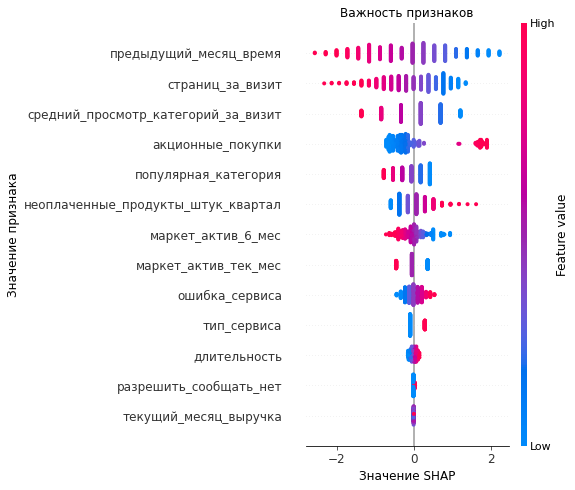

In [90]:
importance(shap.summary_plot(shap_values, X_transformed, show=False))

**По построенной beeswarm диаграмме можно сказать, что признак предыдущий_месяц_выручка дает больший вклад в обучение модели. То есть при большом количестве проведенного времени на сайте вероятность не потерять статус 'прежний уровень активности' увеличивается, аналогично и с количеством страниц_за_визит, но модель не очень уверенно определяет классы на этих признаках. Большую уверенность дают признаки маркет_актив_6_мес, так как множество shap значений находятся в одной области, аналогично можно сказать и про количество ошибок сервиса, чем меньше возникает ошибок при покупках, тем больше вероятность его остаться в положительном для магазина статусе(прежний уровень)**

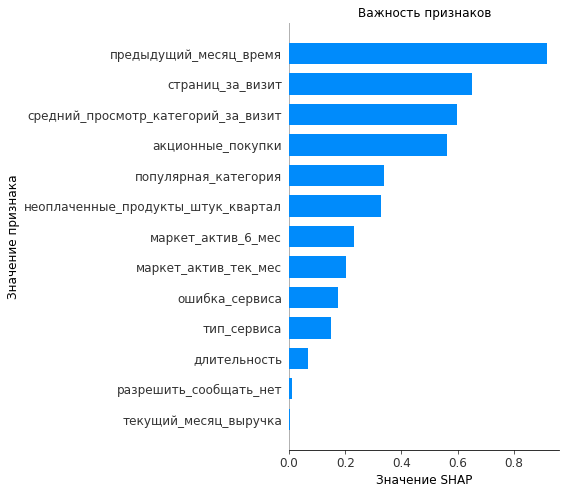

In [91]:
importance(shap.summary_plot(shap_values,
                  X_transformed,
                  plot_type='bar',
                  show=False))

**Показатели диаграммы beeswarm подтверждает данная диаграмма, даёт такую же информацию о важности признаков.**

In [92]:
X_test_df = X_test.copy()
X_test_df['y_test'] = y_test.tolist()
X_test_df['вероятности'] = best_model.predict_proba(X_test)[:, 1]
X_test_df = X_test_df.reset_index('id')
X_test_df.head(7)

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,текущий_месяц_выручка,предыдущий_месяц_время,y_test,вероятности
0,216161,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,3289.2,16,Прежний уровень,0.007208
1,215654,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,4170.7,11,Снизилась,0.985873
2,216307,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,6335.8,20,Прежний уровень,0.048628
3,215501,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,6758.7,9,Снизилась,0.878773
4,215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5773.8,15,Снизилась,0.675348
5,216576,стандарт,да,5.8,4,176,0.28,Домашний текстиль,6,2,4,6,3756.8,18,Прежний уровень,0.020285
6,216465,стандарт,да,4.9,4,739,0.17,Мелкая бытовая техника и электроника,5,1,4,4,5917.6,18,Прежний уровень,0.022101


In [93]:
X_test_df[(X_test_df['y_test']=='Снизилась')&
          (X_test_df['вероятности']<0.5)][['страниц_за_визит','предыдущий_месяц_время', 'y_test']].head()

,страниц_за_визит,предыдущий_месяц_время,y_test
24,15,14,Снизилась
27,17,15,Снизилась
64,8,13,Снизилась
77,11,11,Снизилась
83,10,16,Снизилась


In [94]:
X_test_df[(X_test_df['y_test']=='Прежний уровень')&
          (X_test_df['вероятности']>0.5)][['страниц_за_визит','предыдущий_месяц_время', 'y_test']].head()

,страниц_за_визит,предыдущий_месяц_время,y_test
9,6,13,Прежний уровень
19,4,15,Прежний уровень
202,6,7,Прежний уровень
216,9,15,Прежний уровень
246,4,8,Прежний уровень


**Вывод последних двух срезов таблицы показывает у каких пользователей неверно определен статус. На их основе сделаем выводы какие признаки вводят модель в забуждение.**

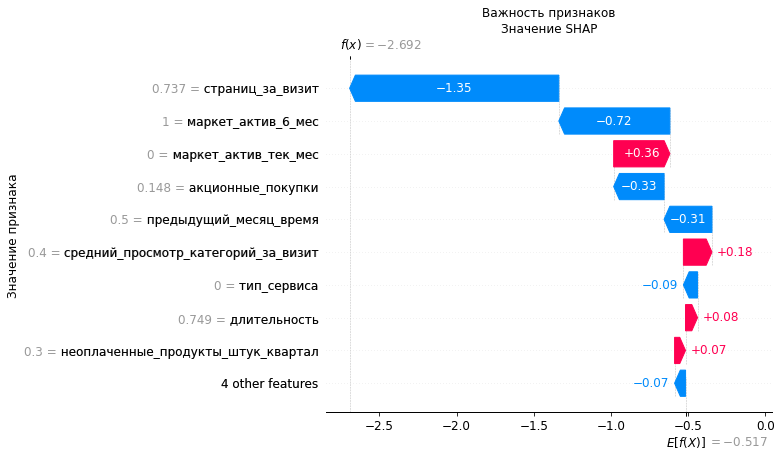

In [95]:
importance(shap.waterfall_plot(shap_values[24], show=False))

**Объект номер 24 был определен с статусом, что у него понизилась активность и на это больше всего повлияли признаки маркет_актив_6_мес и количество просмотренных страниц.**

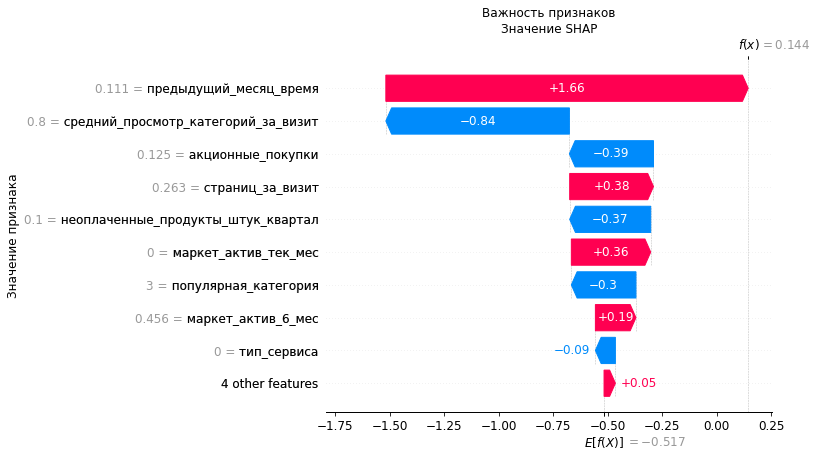

In [96]:
importance(shap.waterfall_plot(shap_values[202], show=False))

**Обратная ситуация, объект 202 был определен со статусом прежний уровень активности, но активность по факту у него снизилась и на это повлиял признак предыдущий_месяц_время.**

<b>Вывод по седьмому шагу: по итогу данного шага было построено 3 типа диаграмм c помощью которых можно сделать следующие выводы при формировании бизнес-решений: 
- Персонализированные предложения: Предлагать специальные скидки или акции клиентам, которые продемонстрировали высокую выручку в предыдущем месяце, чтобы стимулировать их продолжать покупки.
- Лояльность клиентов: Разработать программы лояльности, где клиенты с высокой месячной выручкой получают дополнительные бонусы или награды.
-  Обеспечить удобный интерфейс и навигацию по сайту, чтобы пользователи легко находили нужные товары и информацию.
- Использовать алгоритмы, чтобы рекомендовать пользователям товары на основе их предыдущих просмотров и покупок.
- Повышать качество обслуживания и оперативно решать возникающие проблемы. Внедрить систему обратной связи, чтобы клиенты могли сообщать о возникших проблемах.
 </b>

### Сегментация покупателей

In [97]:
data_big_new_transformed = (best_model.named_steps['preprocessor'].
                            transform(data_big_new.drop(columns='покупательская_активность')))

In [98]:
probs = best_model.named_steps['models'].predict_proba(data_big_new_transformed)[:, 1]

In [99]:
data_big_new['вероятности'] = probs
data_big_new.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,текущий_месяц_выручка,предыдущий_месяц_время,вероятности
id,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,12,0.869267
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,8,0.430294
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,11,0.846936
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,8,0.986242
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,10,0.526697


In [100]:
data_big_new = data_big_new.merge(data_money_all[['id', 'прибыль']], on='id', how='left')

In [101]:
data_big_new.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,текущий_месяц_выручка,предыдущий_месяц_время,вероятности,прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,12,0.869267,4.16
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,8,0.430294,3.13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,11,0.846936,4.87
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,8,0.986242,4.21
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,10,0.526697,3.95


In [102]:
# Сегмент 1: Группа клиентов, которые покупают только технику
segment_1 = data_big_new[data_big_new['популярная_категория'] == 'Мелкая бытовая техника и электроника']
print(segment_1.shape)
segment_1.head()

(174, 17)


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,текущий_месяц_выручка,предыдущий_месяц_время,вероятности,прибыль
46,215398,Снизилась,премиум,да,3.5,5,882,0.22,Мелкая бытовая техника и электроника,3,2,6,3,5854.2,5,0.891627,4.77
115,215467,Снизилась,стандарт,да,4.4,4,503,0.90,Мелкая бытовая техника и электроника,2,3,3,3,5062.3,7,0.973669,4.01
145,215497,Снизилась,премиум,да,5.6,5,719,0.28,Мелкая бытовая техника и электроника,1,2,7,1,6277.1,9,0.882565,4.17
157,215509,Снизилась,премиум,да,4.0,5,982,0.94,Мелкая бытовая техника и электроника,3,1,2,6,5299.3,8,0.885735,3.14
176,215528,Снизилась,стандарт,да,4.4,4,773,0.98,Мелкая бытовая техника и электроника,3,3,8,6,6103.3,8,0.957278,3.33


In [103]:
# Сегмент 2: Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью
segment_2 = data_big_new[(data_big_new['вероятности'] > 0.5) & (data_big_new['прибыль'] > data_big_new['прибыль'].mean())]
print(segment_2.shape)
segment_2.head()

(230, 17)


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,текущий_месяц_выручка,предыдущий_месяц_время,вероятности,прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,12,0.869267,4.16
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,11,0.846936,4.87
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,8,0.986242,4.21
7,215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4566.4,6,0.836162,4.93
9,215360,Снизилась,премиум,да,3.9,3,623,0.35,Кухонная посуда,3,1,4,7,5834.9,9,0.630320,4.55


In [104]:
# Анализ и предложения для сегментов
def analyze_segment(segment, segment_name):
    print(f"--- {segment_name} ---")
    print(f"Количество клиентов: {len(segment)}")
    print(f"Средняя прибыль: {segment['прибыль'].mean():.2f}")
    print(f"Средняя вероятность снижения покупательской активности: {segment['вероятности'].mean():.2f}")
    print(f"Средняя доля акционных покупок: {segment['акционные_покупки'].mean():.2f}")
    print()

In [105]:
# Анализ сегментов
analyze_segment(segment_1, "Сегмент 1: Клиенты, которые покупают только технику")
analyze_segment(segment_2, "Сегмент 2: Высокая вероятность снижения активности и высокая прибыльность")

--- Сегмент 1: Клиенты, которые покупают только технику ---
Количество клиентов: 174
Средняя прибыль: 3.94
Средняя вероятность снижения покупательской активности: 0.18
Средняя доля акционных покупок: 0.27

--- Сегмент 2: Высокая вероятность снижения активности и высокая прибыльность ---
Количество клиентов: 230
Средняя прибыль: 4.76
Средняя вероятность снижения покупательской активности: 0.84
Средняя доля акционных покупок: 0.49



In [106]:
segment_1 = {
    'Количество клиентов': 174,
    'Средняя прибыль': 3.94,
    'Средняя вероятность снижения покупательской активности': 0.18,
    'Средняя доля акционных покупок': 0.27
}

segment_2 = {
    'Количество клиентов': 230,
    'Средняя прибыль': 4.76,
    'Средняя вероятность снижения покупательской активности': 0.84,
    'Средняя доля акционных покупок': 0.49
}

In [107]:
# Создание датафреймов для сегментов
df_segment_1 = pd.DataFrame([segment_1])
df_segment_2 = pd.DataFrame([segment_2])

In [108]:
# Добавление названия сегментов
df_segment_1['Сегмент'] = 'Клиенты, которые покупают только технику'
df_segment_2['Сегмент'] = 'Высокая вероятность снижения активности и высокая прибыльность'
df_segment_1['Сегмент_short'] = 'Сегмент_1'
df_segment_2['Сегмент_short'] = 'Сегмент_2'
# Объединение данных сегментов
df_segments = pd.concat([df_segment_1, df_segment_2], ignore_index=True)

In [109]:
# Аналитическое исследование
print("Аналитическое исследование сегментов:")
df_segments

Аналитическое исследование сегментов:


,Количество клиентов,Средняя прибыль,Средняя вероятность снижения покупательской активности,Средняя доля акционных покупок,Сегмент,Сегмент_short
0,174,3.94,0.18,0.27,"Клиенты, которые покупают только технику",Сегмент_1
1,230,4.76,0.84,0.49,Высокая вероятность снижения активности и высо...,Сегмент_2


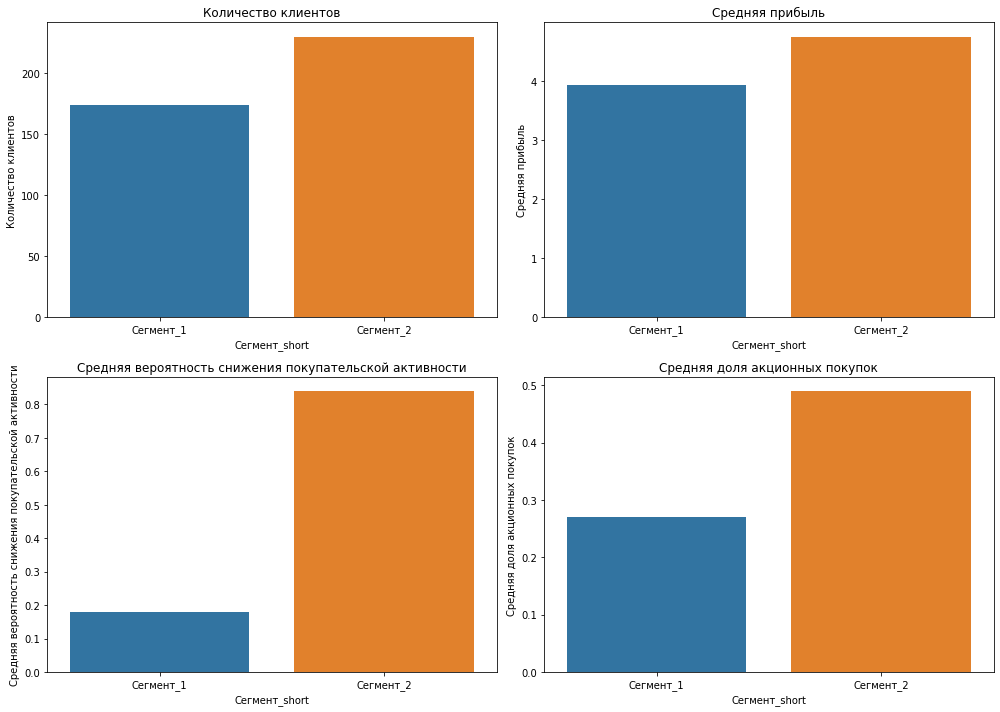

In [110]:
# Графическое исследование
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# Количество клиентов
sns.barplot(x='Сегмент_short', y='Количество клиентов', data=df_segments, ax=axes[0, 0])
axes[0, 0].set_title('Количество клиентов')
# Средняя прибыль
sns.barplot(x='Сегмент_short', y='Средняя прибыль', data=df_segments, ax=axes[0, 1])
axes[0, 1].set_title('Средняя прибыль')
# Средняя вероятность снижения покупательской активности
sns.barplot(x='Сегмент_short', y='Средняя вероятность снижения покупательской активности', data=df_segments, ax=axes[1, 0])
axes[1, 0].set_title('Средняя вероятность снижения покупательской активности')
# Средняя доля акционных покупок
sns.barplot(x='Сегмент_short', y='Средняя доля акционных покупок', data=df_segments, ax=axes[1, 1])
axes[1, 1].set_title('Средняя доля акционных покупок')
plt.tight_layout()
plt.show()

In [111]:
((start_shape - data_big_new.shape[0]) / start_shape) * 100

0.3076923076923077

<b>Вывод по восьмому шагу: На итоговом этапе проекта произведена сегментация покупателей. Выделен сегмент пользователей, которые покупают только технику и второй, у которого высокая вероятность снижения активности и высокая прибыль магазину. получены следующие результаты:
    
Сегмент 1: Клиенты, которые покупают только технику
- Количество клиентов: 174
- Средняя прибыль: 3.94
- Средняя вероятность снижения покупательской активности: 0.18
- Средняя доля акционных покупок: 0.27 
   
Сегмент 2: Высокая вероятность снижения активности и высокая прибыльность
- Количество клиентов: 230
- Средняя прибыль: 4.76
- Средняя вероятность снижения покупательской активности: 0.84
- Средняя доля акционных покупок: 0.49

Анализ произведен с учетом, что разбиение на классы происходило так:
    
- больше 0.5 снизилась активность
- меньше 0.5 прежний уровень
    
Предложения для клиентов, которые покупают только технику:
    
- Увеличить ассортимент техники и предложить уникальные технические новинки.
- Провести рекламные кампании, направленные на повышение лояльности клиентов.
- Организовать программы лояльности для клиентов, покупающих технику.
    
Предложения для клиентов второго сегмента:
    
- Ввести персонализированные предложения и акции для клиентов этого сегмента.
- Анализировать причины снижения активности и принимать меры по их устранению.
- Разработать и предложить программы вознаграждений за регулярные покупки.
</b>

### Итоговый вывод

<b> Итоговый вывод по проекту:
    
В ходе выполнения проекта про анализ активности клиентов онлайн магазина были выполнены следующие шаги:
    
    
1) Загрузка данных: 
    
Загружены необходимые библиотеки shap для построения диаграмм и missingno для провери данных на пропуски. Подключены необходимые библиотеки, функции и атрибуты необходимые для работы. Далее в переменные загружены данные, в таблице с информацией о прибыли были обнаружены проблемы с отображением столбцов, для устранения этого были применены соответствующие параметры в функции загрузки данных. Просмотрены все таблицы, выведена общая информация.
    
2) Предобработка данных: 
    
По итогу предобработки пропусков и явных дубликатов в данных не было обнаружено. Изменены названия столбцов, приведено все к нижнему регистру. Проведена проверка на неявные дубликаты, они были обнаружены и корректно исправлены.
    
3) Исследовательский анализ данных:
    
Построены диаграммы для каждого столбца данных соответствующим образом, для количественных - гистограммы, а для категориальных - круговая диаграмма. Было выявлено, что количественных признаков с нормальным распределением мало - 3, что в дальнейшем повлияет на корреляционный анализ, а некоторые виды категориальных признаков находятся в равном соотношении друг с другом. После просмотра зависимости столбца про выручку было сделано решение убрать аномалии и выбивающиеся значения, а именно нулевую выручку магазина с пользователя и слишком большую, которая свыше 100_000. Таким образом, датасем data_main был уменьшен. По итогу всех преобразований над данными было удалено 3 % строк, что является приемлимым.
    
4) Объединение таблиц:
    
Обработаны таблицы data_money_duration, data_time для отображения данных за каждый из рассматриваемых периодов времени. И было произвдено объединение с data_main. Изменены названия столбцов.
    
5) Корреляционный анализ:
    
В исследовательскомом анализе данных было видно, что мало какие признаки имели нормальное распределение, поэтому нужно использовать корреляцию по Кэндалу или Спирмену, в данному случае была построена по Спирмену. В итоге было обнаружено, что признаки препредыдущий_месяц_выручка, текущий_месяц_время и предыдущий_месяц_время имеют практически одинаковую корреляционную структуру, поэтому 3 признака можно описать одним. Было решено оставить предыдущий_месяц_время. Также по структуре схожи текущий_месяц_выручка и предыдущий_месяц_выручка, их тоже можно описать одним признаком, был убран предыдущий месяц выручка.
    
6) Построение модели:
    
На этом этапе была найдена лучшая модель по по метрике roc_auc_score. Ей оказалась модель Логистической регрессии с гиперпараметром C = 7 и соответственно l2-регуляризацией, метрика roc_auc_score оказалась равна на тренировочной выборке равной 0.892 и чуть больше на тестовой 0.912, что говорит о хорошем качестве модели. Метрика roc_auc_score была выбрана, потому что ROC AUC хорошо справляется с оценкой моделей на таких несбалансированных данных, что было выявлено из исследовательского анализа, поскольку она оценивает модель на всех порогах отсечения, а не на одном фиксированном.
    
7) Анализ важности признаков:
    
Было построено 3 вида диаграмм: beeswarm, bar, waterfall.
    
- Beeswarm:

    По построенной beeswarm диаграмме можно сказать, что признак предыдущий_месяц_выручка дает больший вклад в обучение модели. То есть при большом количестве проведенного времени на сайте вероятность не потерять статус 'прежний уровень активности' увеличивается, аналогично и с количеством страниц_за_визит, но модель не очень уверенно определяет классы на этих признаках. Большую уверенность дают признаки маркет_актив6мес, так как множество shap значений находятся в одной области, аналогично можно сказать и про количество ошибок сервиса, чем меньше возникает ошибок при покупках, тем больше вероятность его остаться в положительном для магазина статусе(прежний уровень).
    
- Bar:
    
    Столбчатая диаграмма подтвердила результаты beeswarm.
- Waterfall:
    
    C помощью этого графика были выявлены признаки, которые вводят в заблуждение модель. Рассмотрены соответственно ошибка на категории 'снизилась' и 'прежний уровень'. Один из объектов был определен с статусом, что у него понизилась активность и на это больше всего повлияли признаки маркет_актив_6_мес и количество просмотренных страниц. Второй объект  был определен со статусом прежний уровень активности, но активность по факту у него снизилась и на это повлиял признак предыдущий_месяц_время.
    
8) Сегментация покупателей:
    
Выделен сегмент пользователей, которые покупают только технику и второй, у которого высокая вероятность снижения активности и высокая прибыль магазину. Сформулированы предложения по увеличению покупательской активности.
    

Предложения для клиентов, которые покупают только технику:
    
- Увеличить ассортимент техники и предложить уникальные технические новинки.
- Провести рекламные кампании, направленные на повышение лояльности клиентов.
- Организовать программы лояльности для клиентов, покупающих технику.
    
Предложения для клиентов второго сегмента:
    
- Ввести персонализированные предложения и акции для клиентов этого сегмента.
- Анализировать причины снижения активности и принимать меры по их устранению.
- Разработать и предложить программы вознаграждений за регулярные покупки.
</b>